<IPython.core.display.Javascript object>


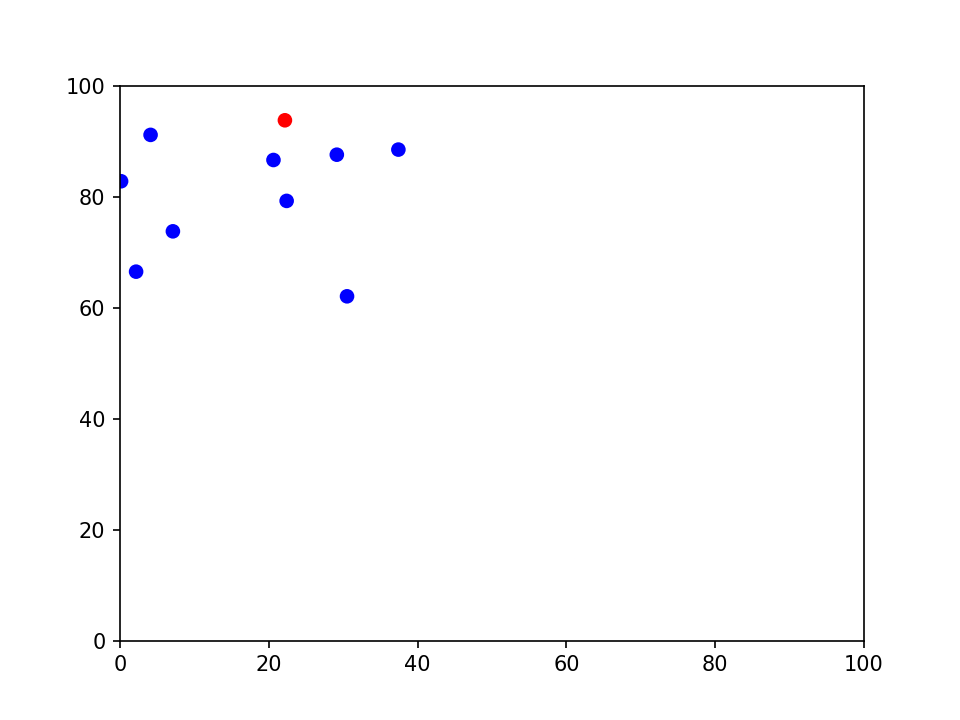

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Simulation parameters
NUM_AGENTS = 10
ARENA_SIZE = 100
TIME_STEPS = 100
COMM_RADIUS = 25.0
MAX_SPEED = 2.0
MIN_DIST = 10.0  # Minimum distance between drones to avoid collisions

# Agent class with roles and separation behavior
class DroneAgent:
    def __init__(self, agent_id, role='follower'):
        self.id = agent_id
        self.position = np.random.rand(2) * ARENA_SIZE
        self.velocity = (np.random.rand(2) - 0.5) * MAX_SPEED
        self.role = role

    def update_state(self, agents, leader=None, frame=0):
        min_separation = 10
        repulsion_force = np.zeros(2)

        if self.role == 'leader':
            # Leader follows a circular trajectory
            direction = np.array([np.cos(frame / 20), np.sin(frame / 20)])
            self.velocity = direction * MAX_SPEED * 0.5
        else:
            # Leader-following
            if leader:
                to_leader = leader.position - self.position
                self.velocity += to_leader * 0.01

            # Neighbor awareness
            neighbors = [
                a for a in agents
                if a.id != self.id and np.linalg.norm(a.position - self.position) < COMM_RADIUS
            ]

            # Cohesion (move toward center of mass)
            if neighbors:
                center = np.mean([n.position for n in neighbors], axis=0)
                self.velocity += (center - self.position) * 0.005  # cohesion

            # Separation (avoid collisions)
            for neighbor in neighbors:
                dist = np.linalg.norm(self.position - neighbor.position)
                if dist < min_separation:
                    repel = self.position - neighbor.position
                    if np.linalg.norm(repel) != 0:
                        repel_unit = repel / np.linalg.norm(repel)
                        repulsion_force += repel_unit * (min_separation - dist)

            self.velocity += repulsion_force * 0.1  # apply strong repulsion

        # Update position and clip to arena
        self.velocity = np.clip(self.velocity, -MAX_SPEED, MAX_SPEED)
        self.position += self.velocity
        self.position = np.clip(self.position, 0, ARENA_SIZE)

# Create agents and assign leader
agents = [DroneAgent(i) for i in range(NUM_AGENTS)]
agents[0].role = 'leader'  # First agent is the leader

# Setup visualization
fig, ax = plt.subplots()
sc = ax.scatter(
    [a.position[0] for a in agents],
    [a.position[1] for a in agents],
    c=["red" if a.role == "leader" else "blue" for a in agents]
)
ax.set_xlim(0, ARENA_SIZE)
ax.set_ylim(0, ARENA_SIZE)

# Animation loop
def animate(frame):
    leader = agents[0]
    for agent in agents:
        agent.update_state(agents, leader=leader, frame=frame)
    sc.set_offsets([a.position for a in agents])
    sc.set_color(["red" if a.role == "leader" else "blue" for a in agents])
    return sc,

# Start animation
anim = animation.FuncAnimation(fig, animate, frames=TIME_STEPS, interval=200)
plt.show()
